In [1]:
from nde.dataframes import read_csv, split
import random
import string
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 18102022
np.random.seed(SEED)
random.seed(SEED)

def generation_from_age(age):
    if age <= 28:
        return "genz"
    elif age <= 44:
        return "millenials"
    elif age <= 60:
        return "genx"
    else:
        return "boomers"

def count_sentences(text):
    sentences = re.split(r'[.!?]+(?:\s|$)', text)
    sentences = [s for s in sentences if s.strip()]
    return len(sentences)  

def lies_about_age(age):
    ages = [age]
    if random.random() > 0.5:
        ages.append(max(21, age - 20))
    if random.random() > 0.25:
        ages.append(max(21, age - 10))        

    return ages

letters = read_csv('synthetic_letters_with_attributes.csv', header=0)
generational = read_csv('generational.csv', header=0)

letters = letters.filter('age >= 21')
letters = letters.filter('education.notnull()')
letters = letters.project('num_sentences_in_letter', ['letter'], count_sentences)

train_df, rest = split(letters, 0.5)
valid_df, test_df = split(rest, 0.5)

train_df = train_df.flatmap('age', ['age'], lies_about_age)

train_df = train_df.project('generation', ['age'], generation_from_age)
train_df = train_df.join(generational, left_on="generation", right_on="generation_name")

valid_df = valid_df.project('generation', ['age'], generation_from_age)
valid_df = valid_df.join(generational, left_on="generation", right_on="generation_name")

test_df = test_df.project('generation', ['age'], generation_from_age)
test_df = test_df.join(generational, left_on="generation", right_on="generation_name")

train_df.view_df()

,age,sector,education,letter,label,num_sentences_in_letter,generation,generation_name,birth_years,loyal,disciplined,tech_savvy,respect_authority,competitive,purpose_driven,work_life_balance,financially_cautious,feedback_seeking,diversity_conscious
0,24,health,trainee,"To Whom It May Concern,\n\nI am writing to rec...",neutral,6,genz,genz,1997–2012,No,No,Yes,No,Somewhat,Yes,Yes,Yes,Yes,Yes
1,28,software engineering,college,"To Whom It May Concern,\n\nI am writing to rec...",neutral,6,genz,genz,1997–2012,No,No,Yes,No,Somewhat,Yes,Yes,Yes,Yes,Yes
2,21,software engineering,college,"To Whom It May Concern,\n\nI am writing to rec...",neutral,6,genz,genz,1997–2012,No,No,Yes,No,Somewhat,Yes,Yes,Yes,Yes,Yes
3,22,ecommerce,college,"To Whom It May Concern,\n\nI am writing to pro...",negative,6,genz,genz,1997–2012,No,No,Yes,No,Somewhat,Yes,Yes,Yes,Yes,Yes
4,21,health,college,"To whom it may concern,\n\nI am pleased to rec...",positive,6,genz,genz,1997–2012,No,No,Yes,No,Somewhat,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,50,finance,trainee,"To Whom It May Concern,\n\nI am pleased to rec...",positive,6,genx,genx,1965–1980,Somewhat,Somewhat,Yes,Somewhat,Yes,Somewhat,Yes,Yes,Somewhat,Somewhat
137,59,software engineering,college,"To whom it may concern,\n\nI regret to inform ...",negative,6,genx,genx,1965–1980,Somewhat,Somewhat,Yes,Somewhat,Yes,Somewhat,Yes,Yes,Somewhat,Somewhat
138,49,software engineering,college,"To whom it may concern,\n\nI regret to inform ...",negative,6,genx,genx,1965–1980,Somewhat,Somewhat,Yes,Somewhat,Yes,Somewhat,Yes,Yes,Somewhat,Somewhat
139,60,ecommerce,college,"To Whom It May Concern,\n\nI am writing to rec...",neutral,6,genx,genx,1965–1980,Somewhat,Somewhat,Yes,Somewhat,Yes,Somewhat,Yes,Yes,Somewhat,Somewhat


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

went_to_college = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('college_or_phd', FunctionTransformer(lambda x: (x == 'college') | (x == 'phd'))),
])

numerics = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
])

feature_encoding = ColumnTransformer([
    ('at_least_college', went_to_college, ['education']),
    ('sector_one_hot', OneHotEncoder(), ['sector', 'work_life_balance', 'financially_cautious']),    
    ('age', numerics, ['age', 'num_sentences_in_letter']),
    ('encoded_letters', HashingVectorizer(ngram_range=(1, 3), n_features=1000), 'letter'),
], sparse_threshold=0.0)

pipeline = [
    feature_encoding, SGDClassifier(loss='log_loss', random_state=SEED)
]

In [3]:
letters_source_provenance = train_df.view_provenance(source='synthetic_letters_with_attributes.csv')
generation_source_provenance = train_df.view_provenance(source='generational.csv')

train_provenance = list(zip(letters_source_provenance, generation_source_provenance)) 
train_provenance[:10]

[([144], [4]),
 ([121], [4]),
 ([121], [4]),
 ([83], [4]),
 ([40], [4]),
 ([134], [1]),
 ([134], [2]),
 ([25], [2]),
 ([13], [4]),
 ([13], [4])]

In [4]:
provenance_identifier_to_indexes = {}
for index, identifiers in enumerate(letters_source_provenance):
    identifier = identifiers[0]
    if identifier not in provenance_identifier_to_indexes:
        provenance_identifier_to_indexes[identifier] = []
    provenance_identifier_to_indexes[identifier].append(index)  

def deduplicate_list(seq):
    seen = set()
    result = []
    for item in seq:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result

provenance_identifiers = [tuple_identifiers[0] for tuple_identifiers in letters_source_provenance]
unique_provenance_identifiers = deduplicate_list(provenance_identifiers)    

In [5]:
from nde.utility import SklearnPipelineAccuracy

train = train_df.view_df()
test = test_df.view_df()

utility = SklearnPipelineAccuracy(pipeline)
utility(train, train.label, test, test.label).score

0.8064516129032258

In [6]:
import copy

def inject_label_errors(original_labels, unique_identifiers, identifier_to_indexes, fraction):
    labels_with_errors = copy.deepcopy(list(original_labels))
    
    count = int(len(unique_identifiers) * fraction)
    
    identifiers_for_errors = np.random.choice(unique_identifiers, count, replace=True)

    possible_labels = deduplicate_list(original_labels)

    for identifier in identifiers_for_errors:
        first_index = identifier_to_indexes[identifier][0]
        true_label = labels_with_errors[first_index]
        other_labels = [label for label in possible_labels if label != true_label]
        new_labels = np.random.choice(other_labels)
        
        for idx in identifier_to_indexes[identifier]:
            labels_with_errors[idx] = np.random.choice(other_labels)

    return labels_with_errors, identifiers_for_errors    

train_mislabeled, identifiers_for_errors = \
    inject_label_errors(train.label, unique_provenance_identifiers, provenance_identifier_to_indexes, fraction=0.5)

utility(train, train_mislabeled, test, test.label).score    

0.6774193548387096

In [7]:
from datascope.utility.provenance import Provenance, Units, Equality

units = Units(units=unique_provenance_identifiers, candidates=[0,1])

expressions = [Equality(units[identifier], 1) for identifier in provenance_identifiers]

provenance = Provenance(expressions=expressions)

In [8]:
from nde.importances import PipelineImportance
from nde.importances import LooImportance

loo_importance = PipelineImportance(utility, LooImportance)
valid = valid_df.view_df()

loo_values = loo_importance.fit(train, train_mislabeled, provenance=provenance).score(valid, valid.label)

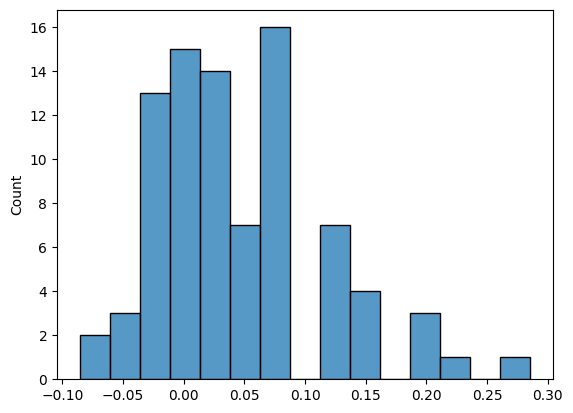

In [9]:
sns.histplot(data=loo_values, binwidth=0.025)
plt.show()

In [10]:
from datascope.importance.shapley import ShapleyImportance, ImportanceMethod
dsv_importance = PipelineImportance(utility, ShapleyImportance, method=ImportanceMethod.NEIGHBOR)

dsvs = dsv_importance.fit(train, train_mislabeled, provenance=provenance).score(valid, valid.label)

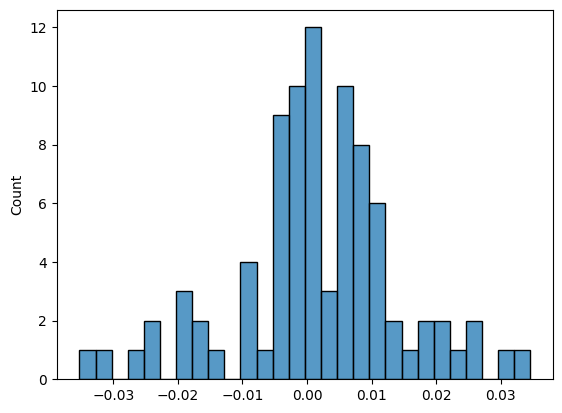

In [11]:
sns.histplot(data=dsvs, binwidth=0.0025)
plt.show()

In [12]:
from IPython.core.display import display, HTML

html = '<ul>'

for pos in np.argsort(dsvs)[:5]:

    identifier = units._units[pos]
    value = dsvs[pos]
    indexes = provenance_identifier_to_indexes[identifier]
    
    html += f'<li>Input tuple {identifier} with Data Shapley value: {value}, (generates {len(indexes)} training sample(s))<ul>'
    for index in indexes:

        html += f'''
<li>    
<b>Given label</b>: {train_mislabeled[index]}<br/>
<b>True label</b>: {train.iloc[index].label}<br/><br/>

<i>Age: {train.iloc[index].age}, Education: {train.iloc[index].education}, Sector: {train.iloc[index].sector}, Generation: {train.iloc[index].generation}</i><br/><br/>
<i>{train.iloc[index].letter}</i><br/><br/>
</li>
'''
    html += '</ul></li>'
    
html += '</ul>'
display(HTML(html))

In [13]:
def evaluate_repairs(positions_to_repair, train, train_mislabeled, train_labels, test, test_labels, utility):

    repaired_identifiers = []
    true_labels = list(train_labels)
    train_with_repairs = copy.deepcopy(list(train_mislabeled))

    scores = []
    for pos in positions_to_repair:
        # TODO Make arguments
        identifier = units._units[pos]
        repaired_identifiers.append(identifier)
        indices_to_repair = provenance_identifier_to_indexes[identifier]

        for index in indices_to_repair:
            train_with_repairs[index] = true_labels[index]
  
        score = utility(train, train_with_repairs, test, test_labels).score
        scores.append(score)
        
    return scores, repaired_identifiers

In [14]:
num_negative_dsvs = np.sum(dsvs < 0)
positions_to_repair_dsv = np.argsort(dsvs)[:num_negative_dsvs]

repair_scores_dsv, repaired_identifiers = evaluate_repairs(positions_to_repair_dsv, train, train_mislabeled, train.label, test, test.label, utility)

In [15]:
print('Repaired', len(repaired_identifiers), 'Dirty', len(set(repaired_identifiers) & set(identifiers_for_errors)))

Repaired 36 Dirty 17


In [16]:
loo_positions = np.argsort(loo_values)[:num_negative_dsvs]
loo_positions = [idx for idx in loo_positions if loo_values[idx] < 0.0]

repair_scores_loo, repaired_identifiers = evaluate_repairs(loo_positions, train, train_mislabeled, train.label, test, test.label, utility)

In [17]:
print('Repaired', len(repaired_identifiers), 'Dirty', len(set(repaired_identifiers) & set(identifiers_for_errors)))

Repaired 18 Dirty 10


In [18]:
random_positions = np.random.choice(range(len(unique_provenance_identifiers)), num_negative_dsvs, replace=False)

repair_scores_random, repaired_identifiers = evaluate_repairs(random_positions, train, train_mislabeled, train.label, test, test.label, utility)

In [19]:
print('Repaired', len(repaired_identifiers), 'Dirty', len(set(repaired_identifiers) & set(identifiers_for_errors)))

Repaired 36 Dirty 2


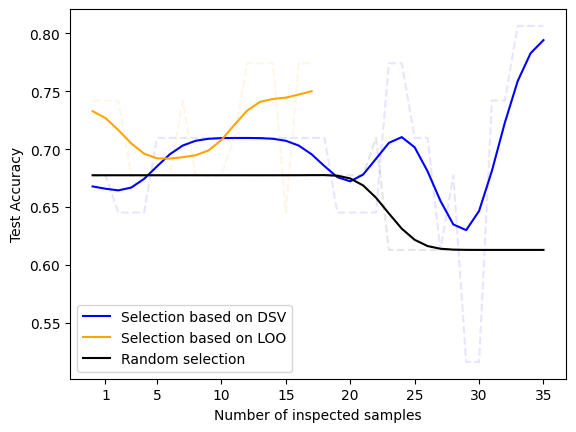

In [32]:
from scipy.ndimage import gaussian_filter1d

alpha = 0.1
sigma = 2

ax = sns.lineplot(repair_scores_dsv, alpha=alpha, color='blue', linestyle='--')
ax = sns.lineplot(gaussian_filter1d(repair_scores_dsv, sigma=sigma), label="Selection based on DSV", color='blue')
ax = sns.lineplot(repair_scores_loo, alpha=alpha, color='orange', linestyle='--')
ax = sns.lineplot(gaussian_filter1d(repair_scores_loo, sigma=sigma), label="Selection based on LOO", color='orange')
ax = sns.lineplot(repair_scores_random, alpha=alpha, color='black', linestyle='--')
ax = sns.lineplot(gaussian_filter1d(repair_scores_random, sigma=sigma), label="Random selection", color='black')


ax.set_xlabel("Number of inspected samples")
ax.set_ylabel("Test Accuracy")
ax.legend()

plt.xticks([1] + list(range(5, len(repair_scores_dsv) + 1, 5)))
plt.show()